In [2]:
# ! pip install kaggle

In [2]:
import fastbook
fastbook.setup_book()

In [4]:
creds = ''

In [3]:
from fastbook import *
Path

pathlib.Path

In [6]:
cred_path = Path('~/.config/kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)
    
cred_path

Path('/home/ubuntu/.config/kaggle/kaggle.json')

In [7]:
path = Path('us-patent-phrase-to-phrase-matching')

In [8]:
# import zipfile, kaggle, os
# kaggle.api.competition_download_cli(str(path))
# zipfile.ZipFile(f'{path}.zip').extractall(path)


import zipfile, kaggle
kaggle.api.competition_download_cli(str(path))
zipfile.ZipFile(f'{path}.zip').extractall(path)

# ! ls /home/ubuntu/

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 682k/682k [00:00<00:00, 2.31MB/s]

In [4]:
path = Path('../input/us-patent-phrase-to-phrase-matching')
! pip install -q datasets

In [5]:
import pandas as pd

In [6]:
df = pd.read_csv(path/'train.csv')

In [7]:
df

,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00
...,...,...,...,...,...
36468,8e1386cbefd7f245,wood article,wooden article,B44,1.00
36469,42d9e032d1cd3242,wood article,wooden box,B44,0.50
36470,208654ccb9e14fa3,wood article,wooden handle,B44,0.50
36471,756ec035e694722b,wood article,wooden material,B44,0.75


In [8]:
df.describe(include='object')

,id,anchor,target,context
count,36473,36473,36473,36473
unique,36473,733,29340,106
top,37d61fd2272659b1,component composite coating,composition,H01
freq,1,152,24,2186


In [9]:
df['input'] = 'TEXT1: ' + df.context + '; TEXT2: ' + df.target + '; ANC1: ' + df.anchor

In [10]:
df.input.head()

0    TEXT1: A47; TEXT2: abatement of pollution; ANC1: abatement
1            TEXT1: A47; TEXT2: act of abating; ANC1: abatement
2           TEXT1: A47; TEXT2: active catalyst; ANC1: abatement
3       TEXT1: A47; TEXT2: eliminating process; ANC1: abatement
4             TEXT1: A47; TEXT2: forest region; ANC1: abatement
Name: input, dtype: object

In [11]:
from datasets import Dataset, DatasetDict
ds = Dataset.from_pandas(df)

In [12]:
ds

Dataset({
    features: ['id', 'anchor', 'target', 'context', 'score', 'input'],
    num_rows: 36473
})

In [13]:
model_nm = 'microsoft/deberta-v3-small'

In [14]:
! pip install protobuf

In [15]:
from transformers import AutoModelForSequenceClassification,AutoTokenizer
tokz = AutoTokenizer.from_pretrained(model_nm)

/home/ubuntu/miniconda3/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/home/ubuntu/miniconda3/lib/python3.12/site-packages/transformers/convert_slow_tokenizer.py:551: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [16]:
tokz.tokenize("G'day folks, I'm Jeremy from fast.ai!")

['▁G',
 "'",
 'day',
 '▁folks',
 ',',
 '▁I',
 "'",
 'm',
 '▁Jeremy',
 '▁from',
 '▁fast',
 '.',
 'ai',
 '!']

In [17]:
tokz.tokenize("A platypus is an ornithorhynchus anatinus.")

['▁A',
 '▁platypus',
 '▁is',
 '▁an',
 '▁or',
 'ni',
 'tho',
 'rhynch',
 'us',
 '▁an',
 'at',
 'inus',
 '.']

In [18]:
def tok_func(x): return tokz(x["input"])


In [19]:
tok_ds = ds.map(tok_func, batched=True)

Map:   0%|          | 0/36473 [00:00<?, ? examples/s]

In [20]:
row = tok_ds[0]
row['input'], row['input_ids']

('TEXT1: A47; TEXT2: abatement of pollution; ANC1: abatement',
 [1,
  54453,
  435,
  294,
  336,
  5753,
  346,
  54453,
  445,
  294,
  47284,
  265,
  6435,
  346,
  23702,
  435,
  294,
  47284,
  2])

In [21]:
tokz.vocab['▁of']

265

In [22]:
tok_ds = tok_ds.rename_columns({'score':'labels'})

In [23]:
tok_ds

Dataset({
    features: ['id', 'anchor', 'target', 'context', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 36473
})

In [24]:
eval_df = pd.read_csv(path/'test.csv')
eval_df.describe()

,id,anchor,target,context
count,36,36,36,36
unique,36,34,36,29
top,4112d61851461f60,el display,inorganic photoconductor drum,G02
freq,1,2,1,3


In [25]:
dds = tok_ds.train_test_split(0.25, seed=42)
dds

DatasetDict({
    train: Dataset({
        features: ['id', 'anchor', 'target', 'context', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 27354
    })
    test: Dataset({
        features: ['id', 'anchor', 'target', 'context', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9119
    })
})

In [26]:
eval_df['input'] = 'TEXT1: ' + eval_df.context + '; TEXT2: ' + eval_df.target + '; ANC1: ' + eval_df.anchor
eval_ds = Dataset.from_pandas(eval_df).map(tok_func, batched=True)

Map:   0%|          | 0/36 [00:00<?, ? examples/s]

In [27]:
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing(as_frame=True)
housing = housing['data'].join(housing['target']).sample(1000, random_state=52)
housing.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
7506,3.0550,37.0,5.152778,1.048611,729.0,5.062500,33.92,-118.28,1.054
4720,3.0862,35.0,4.697897,1.055449,1159.0,2.216061,34.05,-118.37,3.453
12888,2.5556,24.0,4.864905,1.129222,1631.0,2.395007,38.66,-121.35,1.057
13344,3.0057,32.0,4.212687,0.936567,1378.0,5.141791,34.05,-117.64,0.969
7173,1.9083,42.0,3.888554,1.039157,1535.0,4.623494,34.05,-118.19,1.192


In [28]:
np.set_printoptions(precision=2, suppress=True)

np.corrcoef(housing, rowvar=False)

array([[ 1.  , -0.12,  0.43, -0.08,  0.01, -0.07, -0.12,  0.04,  0.68],
       [-0.12,  1.  , -0.17, -0.06, -0.31,  0.  ,  0.03, -0.13,  0.12],
       [ 0.43, -0.17,  1.  ,  0.76, -0.09, -0.07,  0.12, -0.03,  0.21],
       [-0.08, -0.06,  0.76,  1.  , -0.08, -0.07,  0.09,  0.  , -0.04],
       [ 0.01, -0.31, -0.09, -0.08,  1.  ,  0.16, -0.15,  0.13,  0.  ],
       [-0.07,  0.  , -0.07, -0.07,  0.16,  1.  , -0.16,  0.17, -0.27],
       [-0.12,  0.03,  0.12,  0.09, -0.15, -0.16,  1.  , -0.93, -0.16],
       [ 0.04, -0.13, -0.03,  0.  ,  0.13,  0.17, -0.93,  1.  , -0.03],
       [ 0.68,  0.12,  0.21, -0.04,  0.  , -0.27, -0.16, -0.03,  1.  ]])

In [29]:
np.corrcoef(housing.MedInc, housing.MedHouseVal)

array([[1.  , 0.68],
       [0.68, 1.  ]])

In [30]:
def corr(x,y): return np.corrcoef(x,y)[0][1]

corr(housing.MedInc, housing.MedHouseVal)

0.6760250732906005

In [31]:
def show_corr(df, a, b):
    x,y = df[a],df[b]
    plt.scatter(x,y, alpha=0.5, s=4)
    plt.title(f'{a} vs {b}; r: {corr(x, y):.2f}')

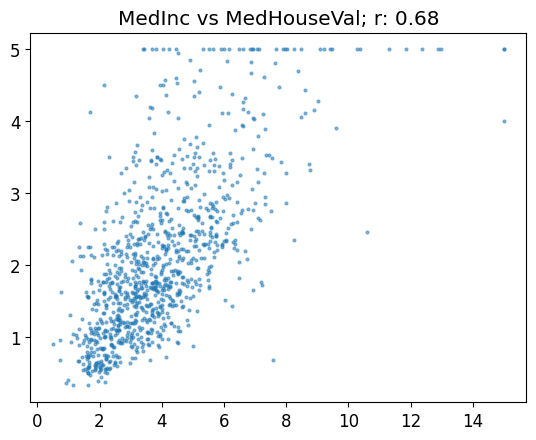

In [32]:
show_corr(housing, 'MedInc', 'MedHouseVal')

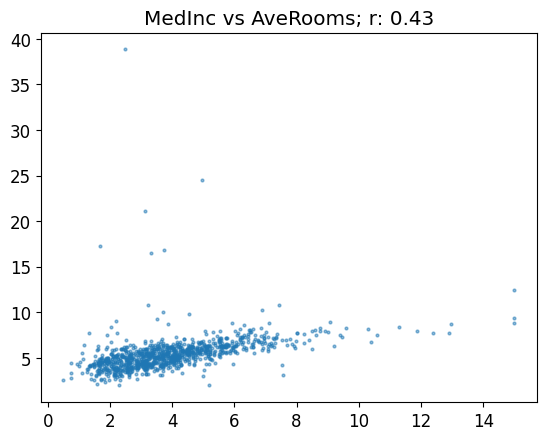

In [33]:
show_corr(housing, 'MedInc', 'AveRooms')

In [34]:
housing['OccupRums'] = (housing.AveRooms+housing.AveBedrms)/housing.AveOccup

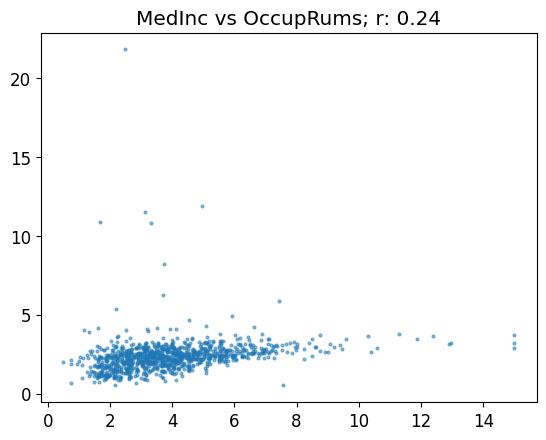

In [35]:
show_corr(housing, 'MedInc', 'OccupRums')

In [36]:
def corr_d(eval_pred): return {'pearson': corr(*eval_pred)}

In [37]:
from transformers import TrainingArguments,Trainer

In [38]:
bs = 128
epochs = 4

In [39]:
lr = 8e-5

In [41]:
# ! pip install -U accelerate
# ! pip install -U transformers

In [40]:
args = TrainingArguments('outputs', learning_rate=lr, warmup_ratio=0.1, lr_scheduler_type='cosine', fp16=True,
    evaluation_strategy="epoch", per_device_train_batch_size=bs, per_device_eval_batch_size=bs*2,
    num_train_epochs=epochs, weight_decay=0.01, report_to='none')

/home/ubuntu/miniconda3/lib/python3.12/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [42]:
model = AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels=1)
trainer = Trainer(model, args, train_dataset=dds['train'], eval_dataset=dds['test'],
                  tokenizer=tokz, compute_metrics=corr_d)

pytorch_model.bin:   0%|          | 0.00/286M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/ubuntu/miniconda3/lib/python3.12/site-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


In [43]:
trainer.train()

Epoch,Training Loss,Validation Loss,Pearson
1,No log,0.032731,0.799265
2,No log,0.023096,0.822297
3,0.033600,0.022065,0.832541
4,0.033600,0.022471,0.832161


TrainOutput(global_step=856, training_loss=0.025184555588481584, metrics={'train_runtime': 126.0001, 'train_samples_per_second': 868.38, 'train_steps_per_second': 6.794, 'total_flos': 715555561923540.0, 'train_loss': 0.025184555588481584, 'epoch': 4.0})

In [44]:
preds = trainer.predict(eval_ds).predictions.astype(float)
preds

array([[ 0.58],
       [ 0.62],
       [ 0.6 ],
       [ 0.36],
       [-0.04],
       [ 0.48],
       [ 0.51],
       [-0.02],
       [ 0.24],
       [ 1.1 ],
       [ 0.28],
       [ 0.26],
       [ 0.7 ],
       [ 0.92],
       [ 0.73],
       [ 0.49],
       [ 0.32],
       [-0.03],
       [ 0.75],
       [ 0.35],
       [ 0.52],
       [ 0.25],
       [ 0.18],
       [ 0.25],
       [ 0.57],
       [-0.02],
       [-0.02],
       [-0.01],
       [-0.02],
       [ 0.63],
       [ 0.31],
       [ 0.01],
       [ 0.73],
       [ 0.53],
       [ 0.46],
       [ 0.17]])

In [45]:
preds = np.clip(preds, 0, 1)

In [46]:
preds

array([[0.58],
       [0.62],
       [0.6 ],
       [0.36],
       [0.  ],
       [0.48],
       [0.51],
       [0.  ],
       [0.24],
       [1.  ],
       [0.28],
       [0.26],
       [0.7 ],
       [0.92],
       [0.73],
       [0.49],
       [0.32],
       [0.  ],
       [0.75],
       [0.35],
       [0.52],
       [0.25],
       [0.18],
       [0.25],
       [0.57],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.63],
       [0.31],
       [0.01],
       [0.73],
       [0.53],
       [0.46],
       [0.17]])

In [47]:
import datasets

submission = datasets.Dataset.from_dict({
    'id': eval_ds['id'],
    'score': preds
})

submission.to_csv('submission.csv', index=False)

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

855